In [1]:
# creating paths to src and data folders in the repo
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"

# train test split paths
train_path = data_path / 'binary_tts/train'
test_path = data_path / 'binary_tts/test'
val_path = data_path / 'binary_tts/val'

# add src path to sys.path so it is searched in import statements
sys.path.append(str(src_path))

# basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# silence max image size warning
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000 

# import modeling packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# modeling metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

changes to data generators:
    
    interpolation 'bicubic'
    
    target_size 200x200 -> 300x300
    

In [2]:
train_generator = ImageDataGenerator().flow_from_directory(str(train_path),
                                                           target_size=(300, 300),
                                                           batch_size=20,
                                                           class_mode='binary',
                                                           interpolation='bicubic')
test_generator = ImageDataGenerator().flow_from_directory(str(test_path),
                                                          target_size=(300, 300),
                                                          batch_size=20,
                                                          class_mode='binary',
                                                          interpolation='bicubic',
                                                          shuffle=False)
val_generator = ImageDataGenerator().flow_from_directory(str(val_path),
                                                         target_size=(300, 300),
                                                         batch_size=20,
                                                         class_mode='binary',
                                                         interpolation='bicubic',
                                                         shuffle=False)

Found 6000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


changes to model architecture:
    
    input_shape 200x200m-> 300x300
    
    num conv2d layers 1
    
    output num_nodes 1
    
    output_activation 'sigmoid'
    
    MaxPooling pool_size 5x5

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(35, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Flatten())
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 35)      980       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 35)        0         
_________________________________________________________________
flatten (Flatten)            (None, 121835)            0         
_________________________________________________________________
dense (Dense)                (None, 40)                4873440   
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4

changes to fit:
    
    epochs 6 -> 8
    
    steps_per_epoch 200 -> 300

In [5]:
model.fit(
        train_generator,
        steps_per_epoch=300,
        epochs=8,
        validation_data=test_generator,
        validation_steps=10)

Epoch 1/8
261/300 [=========================>....] - ETA: 2:16 - loss: 14.8417 - accuracy: 0.5621

/opt/anaconda3/envs/new_capstone-env/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


300/300 [==============================] - 1088s 4s/step - loss: 13.0330 - accuracy: 0.5637 - val_loss: 0.7226 - val_accuracy: 0.5700
Epoch 2/8
300/300 [==============================] - 1085s 4s/step - loss: 0.7623 - accuracy: 0.6418 - val_loss: 0.6801 - val_accuracy: 0.6500
Epoch 3/8
300/300 [==============================] - 1082s 4s/step - loss: 0.6032 - accuracy: 0.7067 - val_loss: 0.7628 - val_accuracy: 0.5950
Epoch 4/8
300/300 [==============================] - 1079s 4s/step - loss: 0.5108 - accuracy: 0.7570 - val_loss: 0.7797 - val_accuracy: 0.5950
Epoch 5/8
300/300 [==============================] - 1082s 4s/step - loss: 0.4350 - accuracy: 0.8088 - val_loss: 0.8236 - val_accuracy: 0.6000
Epoch 6/8
300/300 [==============================] - 1083s 4s/step - loss: 0.3526 - accuracy: 0.8507 - val_loss: 0.8583 - val_accuracy: 0.6700
Epoch 7/8
300/300 [==============================] - 1078s 4s/step - loss: 0.3083 - accuracy: 0.8843 - val_loss: 1.2471 - val_accuracy: 0.6150
Epoch 8/

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


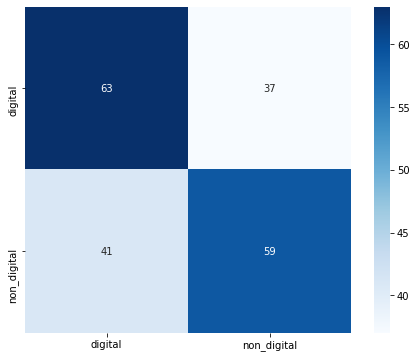

In [6]:
conf_mat = confusion_matrix(test_generator.classes, model.predict_classes(test_generator))

class_names = list(test_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
model_12_path = pathlib.Path().absolute().parent.parent / 'reports/figures/mod_12_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(model_12_path)

In [7]:
accuracies = []
for i in range(0, 2):
    acc = conf_mat[i][i] / sum(conf_mat[i])
    accuracies.append(acc)
accuracies

[0.63, 0.59]